In [1]:
%load_ext autoreload
%autoreload 2

from nnTrain import train_efn, train_pfn, get_data, get_data_softDrop
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K
from energyflow.utils import data_split, to_categorical
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.losses import BinaryCrossentropy

# define rng seeds for train/test/val split for replicable results
rng1 = 45446
rng2 = 25135

2024-01-22 15:32:04.382528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import energyflow as ef
ef.__file__

'/home/sbrightt/.local/lib/python3.9/site-packages/energyflow/__init__.py'

# Hadron Level

In [2]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('q',hlevel=True,efrac=True,base=base,nmax=nmax,wta=True)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('g',hlevel=True,efrac=True,base=base,nmax=nmax,wta=True)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set4_R1.0_mH1000_pTall_WTA.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_

2024-01-04 18:54:58.549886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 18:54:59.273733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 18:54:59.274043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 18:54:59.274677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    601         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    20201       ['activation[0][0]']             
                                                                                              

2024-01-04 18:55:03.772973: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200
20/20 [==============================] - 7s 240ms/step - loss: 0.6889 - acc: 0.6420 - val_loss: 0.6857 - val_acc: 0.6544
Epoch 2/200
20/20 [==============================] - 4s 210ms/step - loss: 0.6849 - acc: 0.6380 - val_loss: 0.6843 - val_acc: 0.6441
Epoch 3/200
20/20 [==============================] - 4s 206ms/step - loss: 0.6842 - acc: 0.6337 - val_loss: 0.6839 - val_acc: 0.6381
Epoch 4/200
20/20 [==============================] - 4s 203ms/step - loss: 0.6840 - acc: 0.6301 - val_loss: 0.6838 - val_acc: 0.6385
Epoch 5/200
20/20 [==============================] - 4s 205ms/step - loss: 0.6839 - acc: 0.6287 - val_loss: 0.6837 - val_acc: 0.6504
Epoch 6/200
20/20 [==============================] - 4s 205ms/step - loss: 0.6838 - acc: 0.6276 - val_loss: 0.6836 - val_acc: 0.6246
Epoch 7/200
20/20 [==============================] - 4s 204ms/step - loss: 0.6838 - acc: 0.6329 - val_loss: 0.6835 - val_acc: 0.6419
Epoch 8/200
20/20 [==============================] - 4s 207ms/step - 

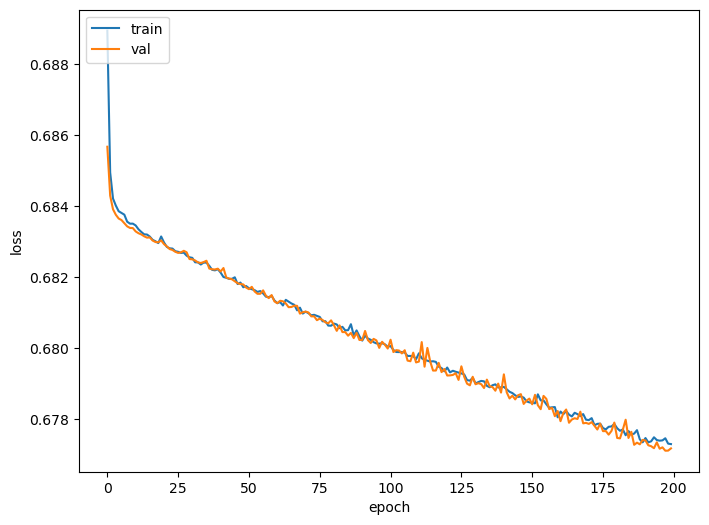

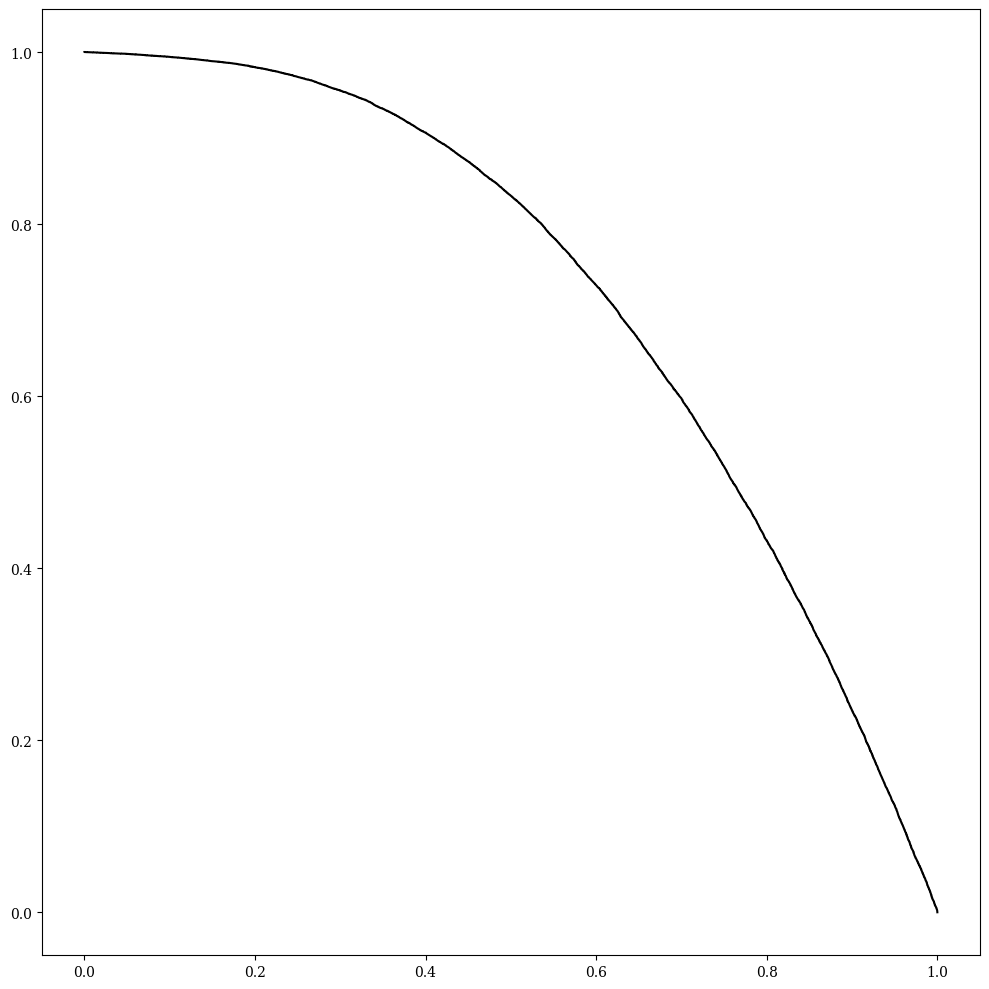

In [3]:
# EFN with spectral normalization
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(100,100,128), "F_sizes":(100,100,100),
                    "F_acts":"relu","Phi_acts":"relu",
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,
                    "output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta_quarkGluon/spectralEFN_zpT_iter{i}.keras")
    del efn
    gc.collect()

2024-01-12 18:30:14.275871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-12 18:30:14.386599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-12 18:30:14.386992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-12 18:30:14.388209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    601         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    20201       ['activation[0][0]']             
                                                                                              

2024-01-12 18:30:16.572952: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200
20/20 [==============================] - 6s 227ms/step - loss: 0.6599 - acc: 0.6339 - val_loss: 0.6330 - val_acc: 0.6818
Epoch 2/200
20/20 [==============================] - 4s 202ms/step - loss: 0.5985 - acc: 0.6911 - val_loss: 0.5632 - val_acc: 0.7107
Epoch 3/200
20/20 [==============================] - 4s 199ms/step - loss: 0.5572 - acc: 0.7185 - val_loss: 0.5439 - val_acc: 0.7327
Epoch 4/200
20/20 [==============================] - 4s 198ms/step - loss: 0.5442 - acc: 0.7306 - val_loss: 0.5388 - val_acc: 0.7354
Epoch 5/200
20/20 [==============================] - 4s 195ms/step - loss: 0.5393 - acc: 0.7349 - val_loss: 0.5374 - val_acc: 0.7350
Epoch 6/200
20/20 [==============================] - 4s 193ms/step - loss: 0.5365 - acc: 0.7373 - val_loss: 0.5329 - val_acc: 0.7395
Epoch 7/200
20/20 [==============================] - 4s 194ms/step - loss: 0.5334 - acc: 0.7393 - val_loss: 0.5315 - val_acc: 0.7404
Epoch 8/200
20/20 [==============================] - 4s 193ms/step - 

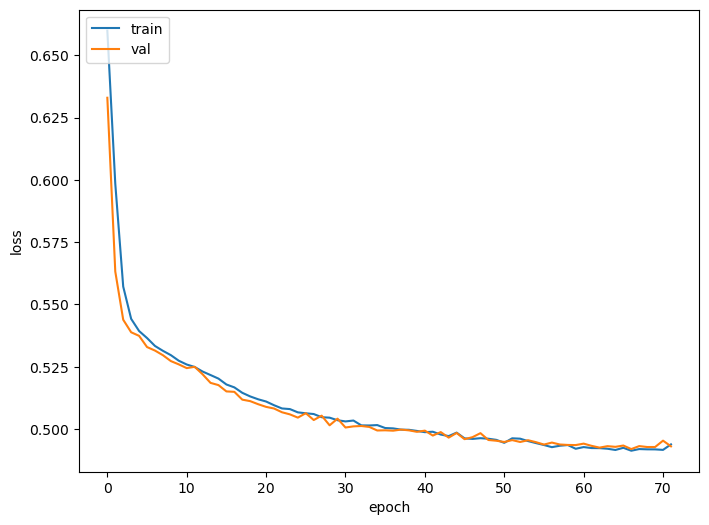

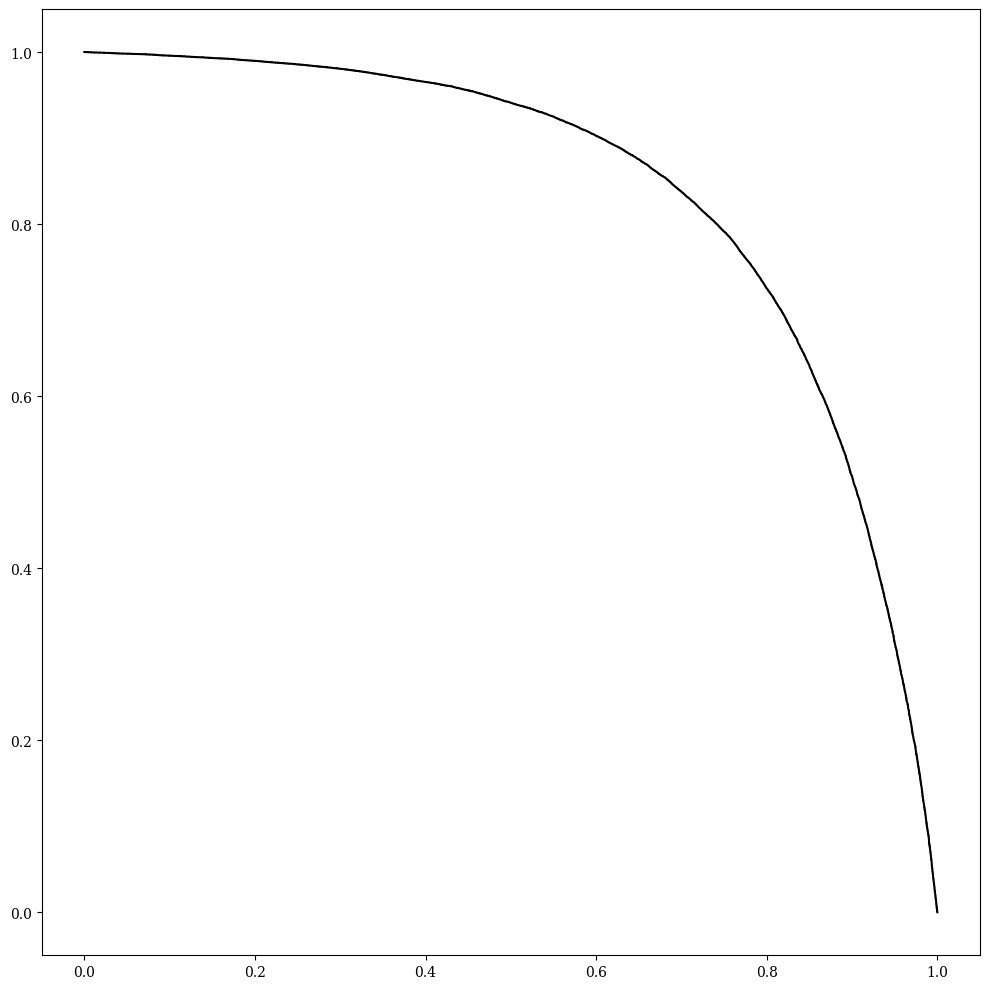

In [3]:
# spectral EFN L > 1
L = 9.0
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(100,100,128), "F_sizes":(100,100,100),
                    "F_acts":"relu","Phi_acts":"relu",
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,
                    "output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    model_kwargs['lip_const'] = L
    model_kwargs['eps_bjorck'] = None
    model_kwargs['bound_only'] = True
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    #efn.save(f"keras_models_wta_quarkGluon/spectralEFN_L{int(L)}_zpT_iter{i}.keras")
    del efn
    gc.collect()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     180         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation[0][0]']             
                                                                                              

2024-01-04 22:45:20.469350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 22:45:20.601674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 22:45:20.602018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 22:45:20.602846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/200
 2/20 [==>...........................] - ETA: 1s - loss: 0.6942 - acc: 0.5009 

2024-01-04 22:45:23.435196: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 4s 131ms/step - loss: 0.6673 - acc: 0.6196 - val_loss: 0.6441 - val_acc: 0.6777
Epoch 2/200
20/20 [==============================] - 2s 112ms/step - loss: 0.6222 - acc: 0.6802 - val_loss: 0.5837 - val_acc: 0.6971
Epoch 3/200
20/20 [==============================] - 2s 111ms/step - loss: 0.5724 - acc: 0.7053 - val_loss: 0.5508 - val_acc: 0.7277
Epoch 4/200
20/20 [==============================] - 2s 111ms/step - loss: 0.5512 - acc: 0.7253 - val_loss: 0.5406 - val_acc: 0.7354
Epoch 5/200
20/20 [==============================] - 2s 112ms/step - loss: 0.5450 - acc: 0.7291 - val_loss: 0.5377 - val_acc: 0.7362
Epoch 6/200
20/20 [==============================] - 2s 111ms/step - loss: 0.5406 - acc: 0.7337 - val_loss: 0.5354 - val_acc: 0.7378
Epoch 7/200
20/20 [==============================] - 2s 111ms/step - loss: 0.5378 - acc: 0.7356 - val_loss: 0.5341 - val_acc: 0.7389
Epoch 8/200
20/20 [==============================] - 2s 111ms/step - loss: 0.5353

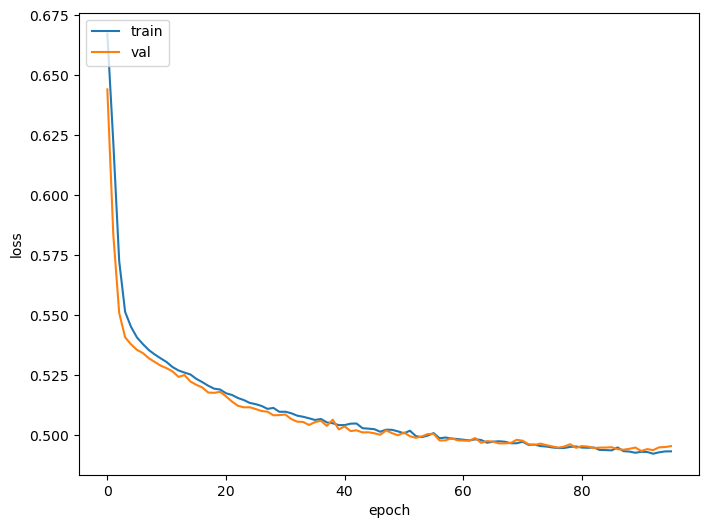

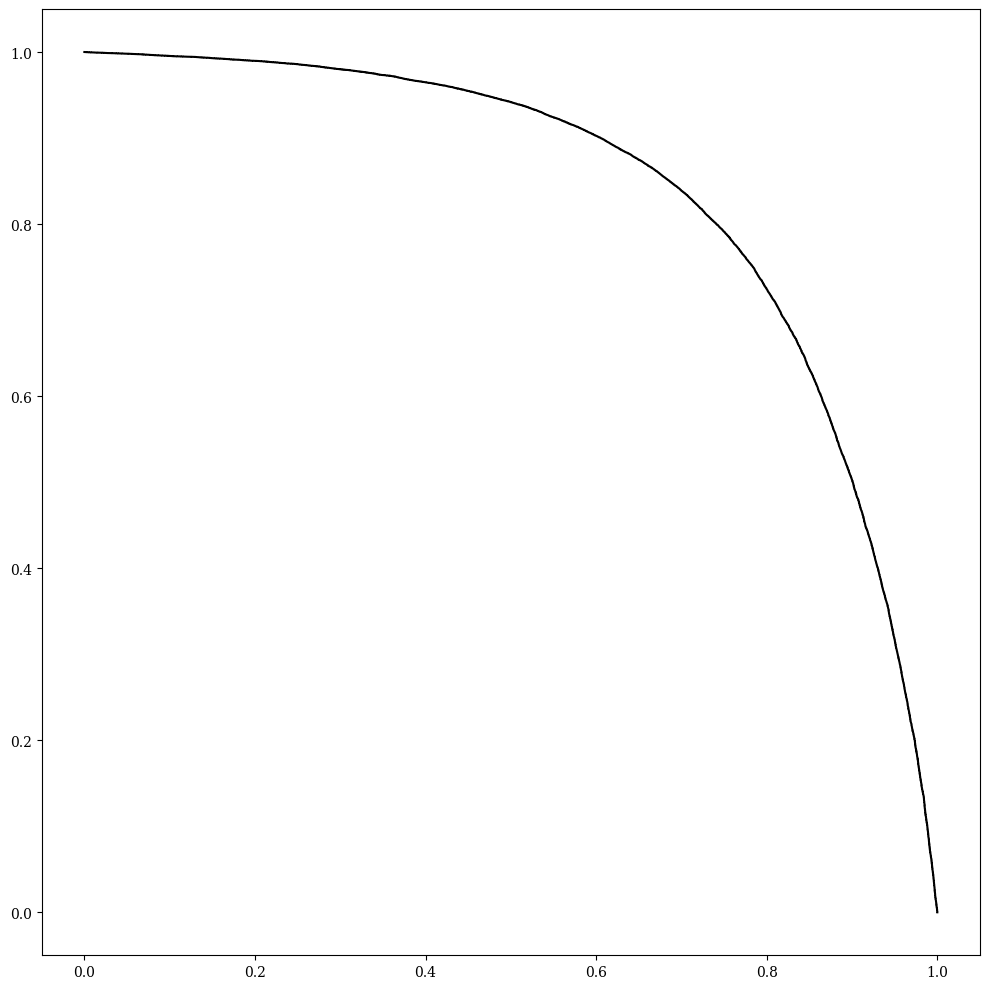

In [3]:
# EFN without spectral normalization
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = False
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta_quarkGluon/EFN_zpT_hadlevel_iter{i}.keras")
    del efn
    gc.collect()

2024-01-08 17:24:35.564001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:24:35.761156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:24:35.761613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:24:35.763160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 3)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     240         ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation[0][0]']             
                                                                                              

ning NUMA node zero
2024-01-08 17:24:36.312443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:24:36.312801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:24:36.313091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:24:36.313376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7934 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:05:00.0, compute capability: 8.0


Epoch 1/200
 2/20 [==>...........................] - ETA: 1s - loss: 2.8148 - acc: 0.4832 

2024-01-08 17:24:38.964851: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 4s 134ms/step - loss: 1.4365 - acc: 0.5389 - val_loss: 0.6412 - val_acc: 0.6447
Epoch 2/200
20/20 [==============================] - 2s 114ms/step - loss: 0.7093 - acc: 0.6352 - val_loss: 0.5679 - val_acc: 0.7216
Epoch 3/200
20/20 [==============================] - 2s 117ms/step - loss: 0.5969 - acc: 0.6985 - val_loss: 0.5380 - val_acc: 0.7398
Epoch 4/200
20/20 [==============================] - 2s 116ms/step - loss: 0.5543 - acc: 0.7284 - val_loss: 0.5182 - val_acc: 0.7559
Epoch 5/200
20/20 [==============================] - 2s 114ms/step - loss: 0.5336 - acc: 0.7443 - val_loss: 0.5119 - val_acc: 0.7604
Epoch 6/200
20/20 [==============================] - 2s 116ms/step - loss: 0.5238 - acc: 0.7506 - val_loss: 0.5064 - val_acc: 0.7627
Epoch 7/200
20/20 [==============================] - 2s 116ms/step - loss: 0.5173 - acc: 0.7554 - val_loss: 0.5036 - val_acc: 0.7645
Epoch 8/200
20/20 [==============================] - 2s 114ms/step - loss: 0.5111

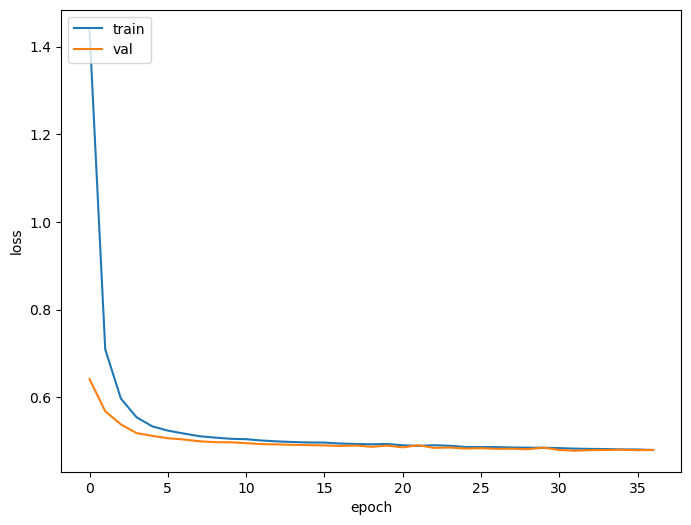

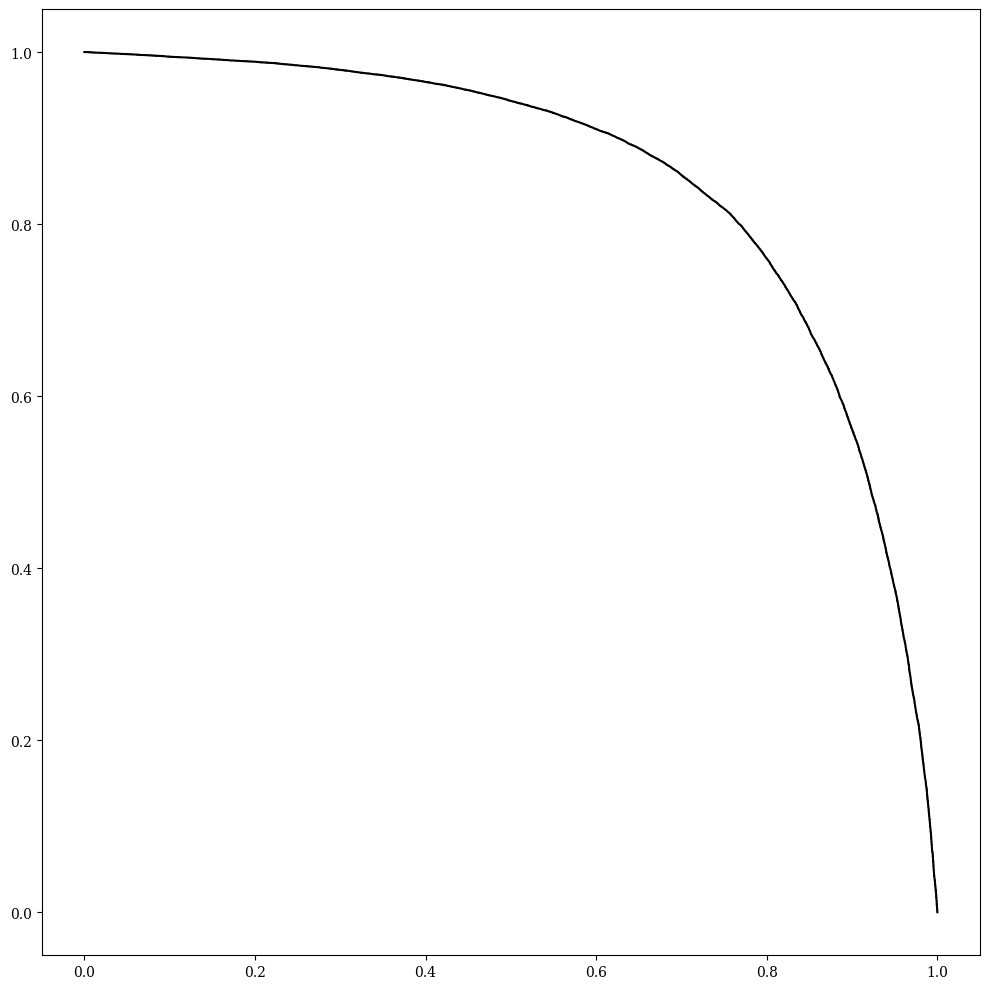

In [3]:
# PFN without spectral normalization
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":3,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = False
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_pfn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta_quarkGluon/PFN_zpT_iter{i}.keras")
    del efn
    gc.collect()

2024-01-08 17:33:13.557468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:33:13.789394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:33:13.789852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:33:13.791100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 3)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     481         ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation[0][0]']             
                                                                                              

2024-01-08 17:33:16.045866: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200
20/20 [==============================] - 5s 154ms/step - loss: 0.6591 - acc: 0.5529 - val_loss: 0.6390 - val_acc: 0.6511
Epoch 2/200
20/20 [==============================] - 3s 133ms/step - loss: 0.6281 - acc: 0.6844 - val_loss: 0.6017 - val_acc: 0.7249
Epoch 3/200
20/20 [==============================] - 3s 135ms/step - loss: 0.5953 - acc: 0.7171 - val_loss: 0.5694 - val_acc: 0.7412
Epoch 4/200
20/20 [==============================] - 3s 134ms/step - loss: 0.5711 - acc: 0.7303 - val_loss: 0.5526 - val_acc: 0.7452
Epoch 5/200
20/20 [==============================] - 3s 135ms/step - loss: 0.5549 - acc: 0.7373 - val_loss: 0.5388 - val_acc: 0.7524
Epoch 6/200
20/20 [==============================] - 3s 134ms/step - loss: 0.5448 - acc: 0.7404 - val_loss: 0.5323 - val_acc: 0.7525
Epoch 7/200
20/20 [==============================] - 3s 133ms/step - loss: 0.5382 - acc: 0.7434 - val_loss: 0.5251 - val_acc: 0.7570
Epoch 8/200
20/20 [==============================] - 3s 133ms/step - 

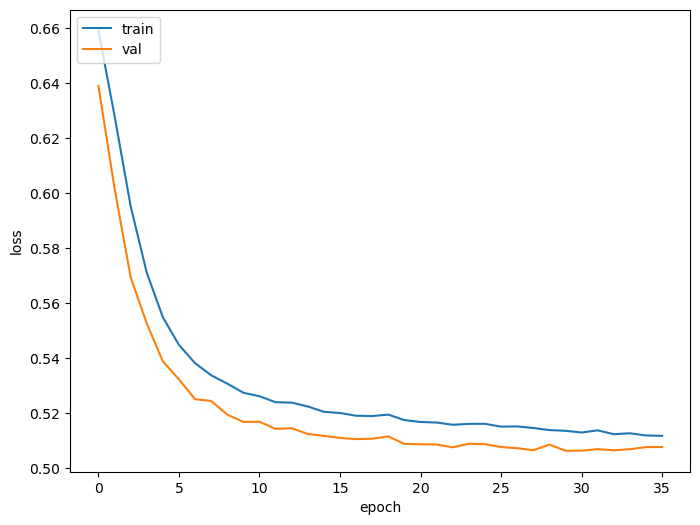

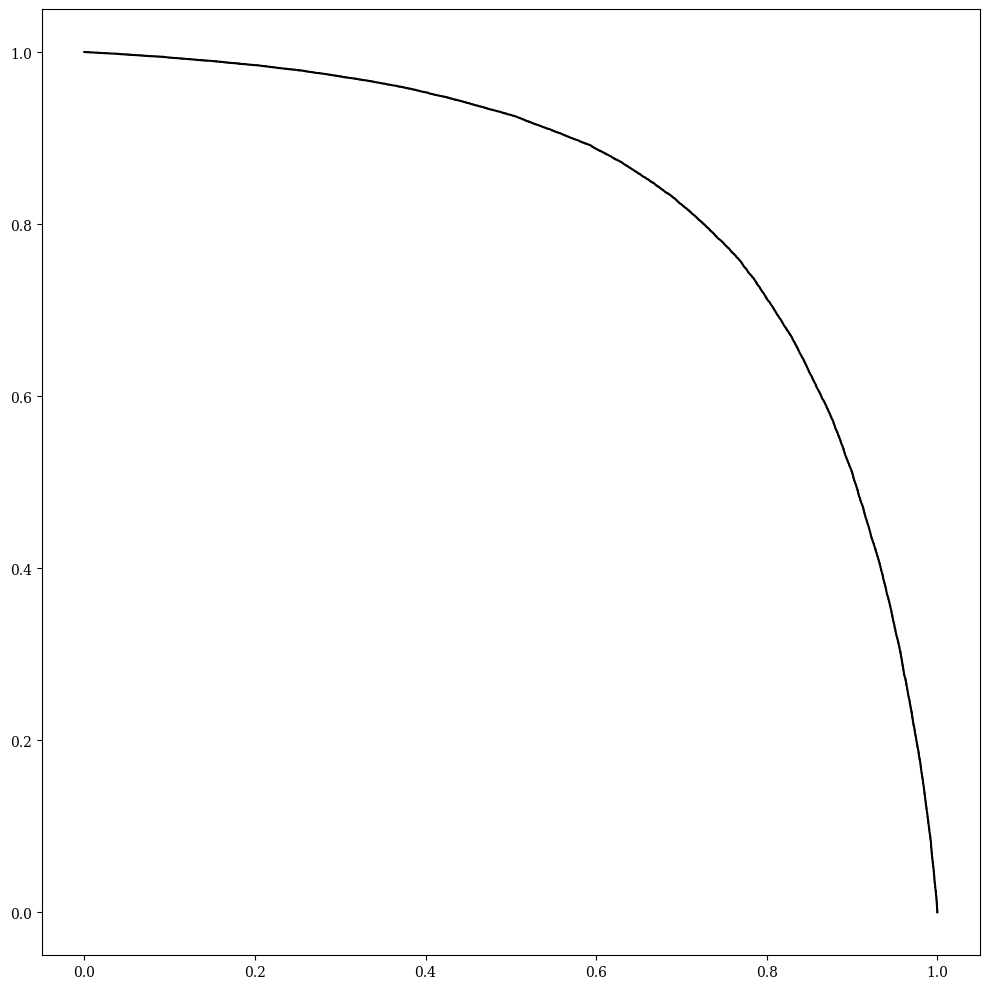

In [3]:
# PFN with spectral normalization
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":3,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_pfn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta_quarkGluon/spectralPFN_zpT_iter{i}.keras")
    del efn
    gc.collect()

# Parton Level

In [2]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('q',hlevel=False,efrac=True,base=base,nmax=nmax,wta=True)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('g',hlevel=False,efrac=True,base=base,nmax=nmax,wta=True)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set4_R1.0_mH1000_pTall_WTA.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_

2024-01-04 22:53:44.530823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 22:53:44.563699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 22:53:44.564015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-04 22:53:44.564916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     361         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation[0][0]']             
                                                                                              

2024-01-04 22:53:46.409150: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200
20/20 [==============================] - 5s 157ms/step - loss: 0.6928 - acc: 0.6121 - val_loss: 0.6921 - val_acc: 0.6522
Epoch 2/200
20/20 [==============================] - 3s 135ms/step - loss: 0.6917 - acc: 0.6475 - val_loss: 0.6911 - val_acc: 0.6459
Epoch 3/200
20/20 [==============================] - 3s 133ms/step - loss: 0.6908 - acc: 0.6460 - val_loss: 0.6901 - val_acc: 0.6460
Epoch 4/200
20/20 [==============================] - 3s 129ms/step - loss: 0.6898 - acc: 0.6429 - val_loss: 0.6892 - val_acc: 0.6421
Epoch 5/200
20/20 [==============================] - 3s 130ms/step - loss: 0.6890 - acc: 0.6425 - val_loss: 0.6884 - val_acc: 0.6408
Epoch 6/200
20/20 [==============================] - 3s 131ms/step - loss: 0.6882 - acc: 0.6386 - val_loss: 0.6877 - val_acc: 0.6382
Epoch 7/200
20/20 [==============================] - 3s 132ms/step - loss: 0.6876 - acc: 0.6357 - val_loss: 0.6870 - val_acc: 0.6366
Epoch 8/200
20/20 [==============================] - 3s 133ms/step - 

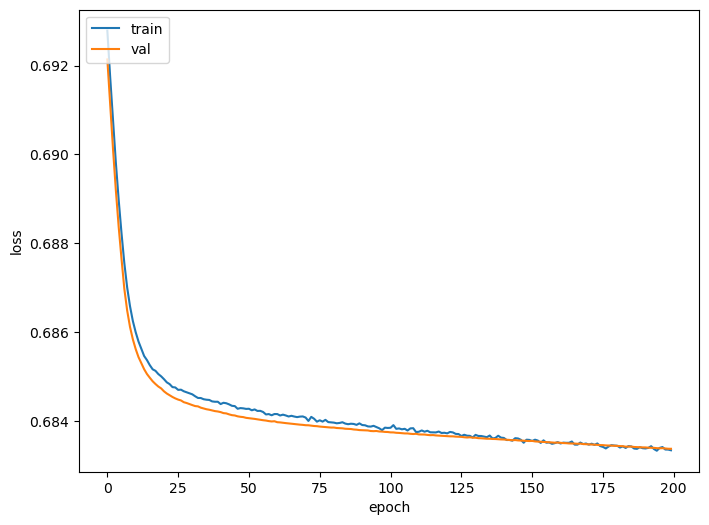

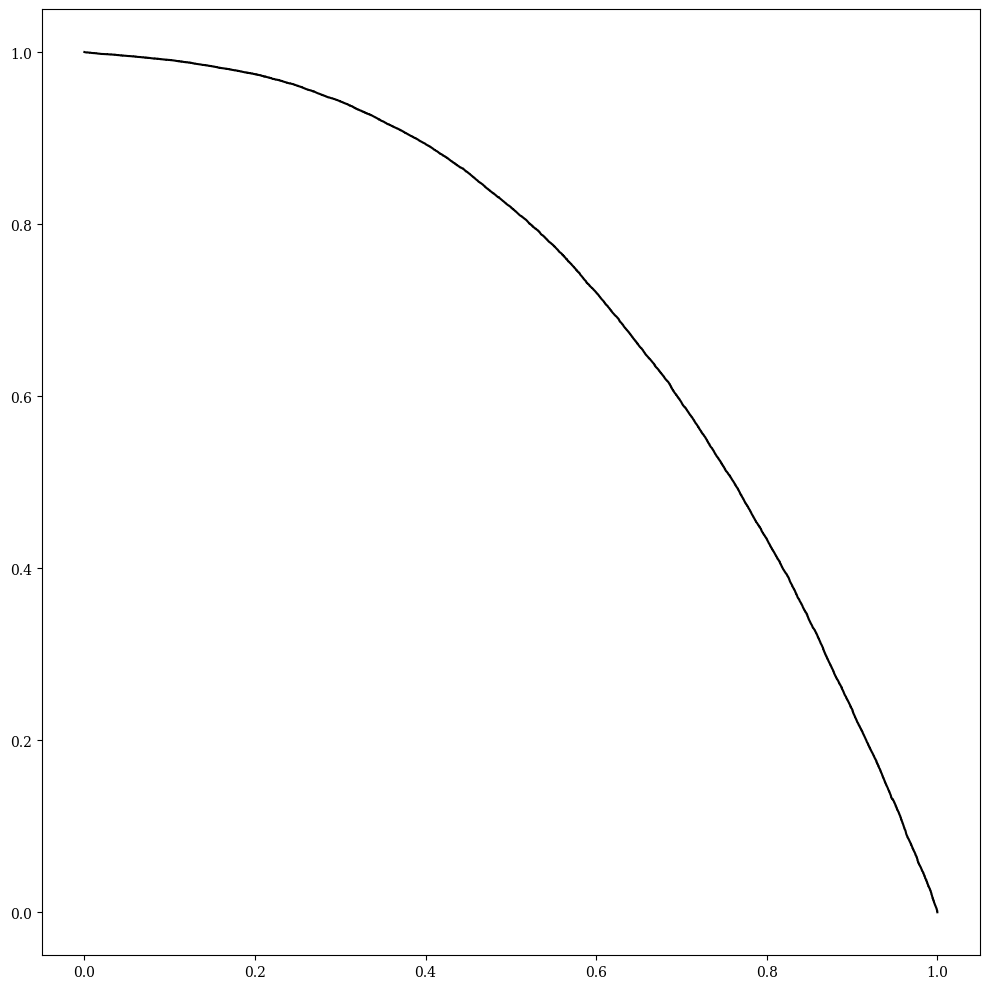

In [4]:
# EFN with spectral normalization
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-4),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta_quarkGluon/spectralEFN_zpT_partlevel_iter{i}.keras")
    del efn
    gc.collect()

2024-01-08 16:50:36.145577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 16:50:36.413026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 16:50:36.413414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 16:50:36.414084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    601         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    20201       ['activation[0][0]']             
                                                                                              

2024-01-08 16:50:38.551644: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200
20/20 [==============================] - 6s 233ms/step - loss: 1621.8672 - acc: 0.5131 - val_loss: 197.6638 - val_acc: 0.5711
Epoch 2/200
20/20 [==============================] - 4s 207ms/step - loss: 328.2173 - acc: 0.5572 - val_loss: 98.6628 - val_acc: 0.6203
Epoch 3/200
20/20 [==============================] - 4s 206ms/step - loss: 158.9763 - acc: 0.5735 - val_loss: 40.7684 - val_acc: 0.6048
Epoch 4/200
20/20 [==============================] - 4s 207ms/step - loss: 99.4898 - acc: 0.5780 - val_loss: 25.1112 - val_acc: 0.6213
Epoch 5/200
20/20 [==============================] - 4s 207ms/step - loss: 66.6072 - acc: 0.5793 - val_loss: 18.5542 - val_acc: 0.6154
Epoch 6/200
20/20 [==============================] - 4s 208ms/step - loss: 45.7270 - acc: 0.5772 - val_loss: 13.7245 - val_acc: 0.6177
Epoch 7/200
20/20 [==============================] - 4s 207ms/step - loss: 31.9776 - acc: 0.5768 - val_loss: 10.4862 - val_acc: 0.6181
Epoch 8/200
20/20 [==============================]

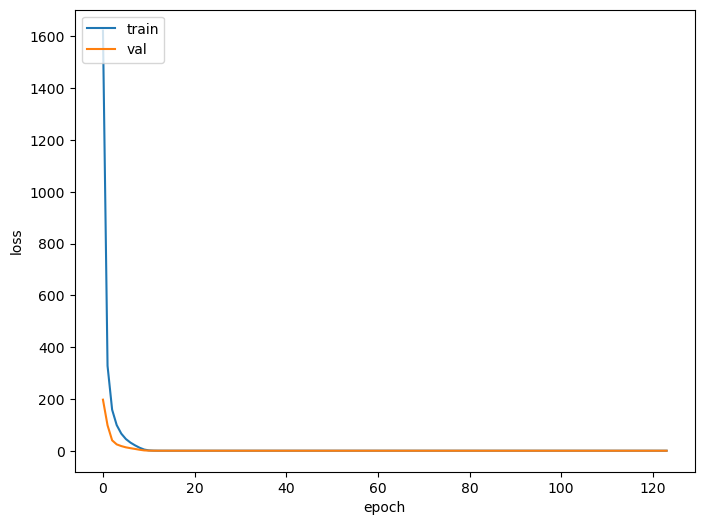

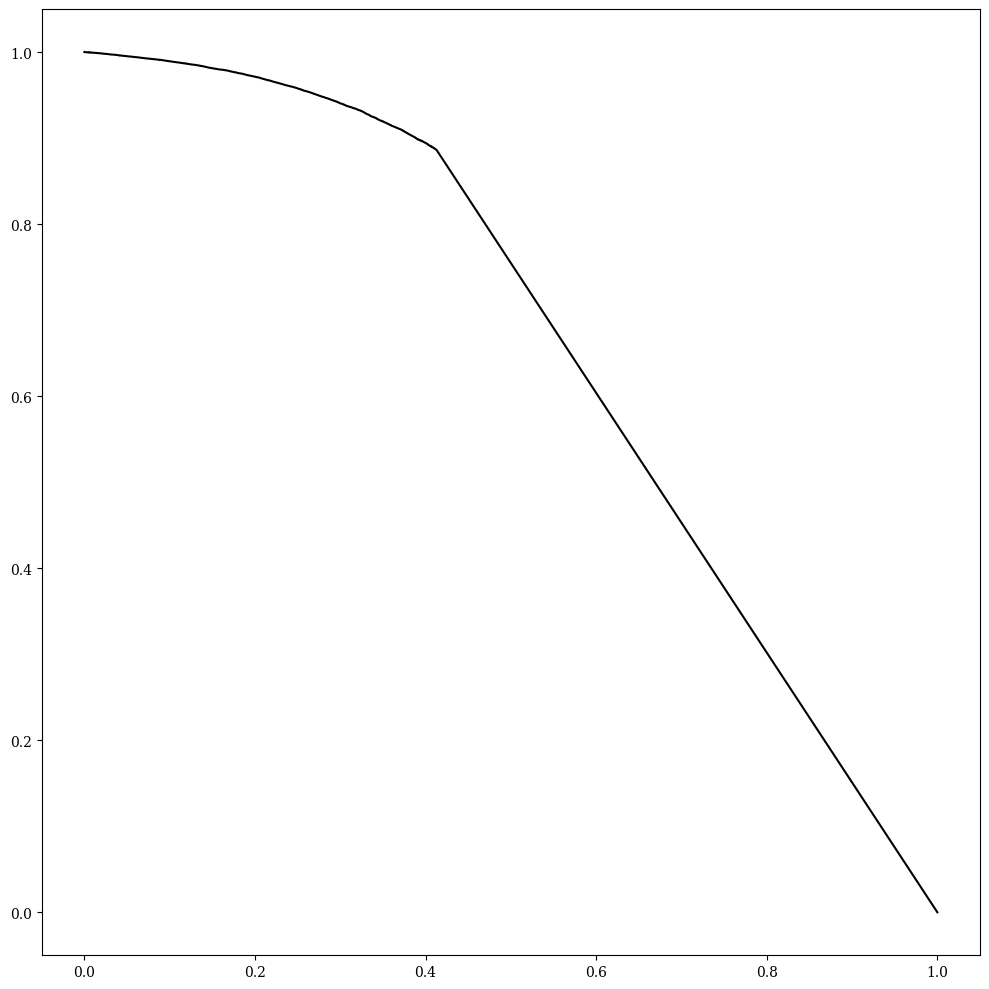

In [3]:
# spectral EFN L > 1
L = 10.0
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(100,100,128), "F_sizes":(100,100,100),
                    "F_acts":"relu","Phi_acts":"relu",
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,
                    "output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    model_kwargs['lip_const'] = L
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta_quarkGluon/spectralEFN_L{int(L)}_zpT_partlevel_iter{i}.keras")
    del efn
    gc.collect()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     180         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation[0][0]']             
                                                                                              

2024-01-08 17:02:17.657163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:02:17.863200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:02:17.863567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:02:17.864352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Epoch 1/200
 2/20 [==>...........................] - ETA: 1s - loss: 0.6935 - acc: 0.4936 

2024-01-08 17:02:20.562317: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 4s 130ms/step - loss: 0.6702 - acc: 0.6026 - val_loss: 0.6526 - val_acc: 0.6648
Epoch 2/200
20/20 [==============================] - 2s 111ms/step - loss: 0.6362 - acc: 0.6647 - val_loss: 0.6102 - val_acc: 0.6740
Epoch 3/200
20/20 [==============================] - 2s 110ms/step - loss: 0.6009 - acc: 0.6799 - val_loss: 0.5857 - val_acc: 0.6910
Epoch 4/200
20/20 [==============================] - 2s 110ms/step - loss: 0.5866 - acc: 0.6931 - val_loss: 0.5804 - val_acc: 0.6974
Epoch 5/200
20/20 [==============================] - 2s 110ms/step - loss: 0.5819 - acc: 0.6987 - val_loss: 0.5769 - val_acc: 0.7049
Epoch 6/200
20/20 [==============================] - 2s 110ms/step - loss: 0.5792 - acc: 0.7012 - val_loss: 0.5758 - val_acc: 0.7051
Epoch 7/200
20/20 [==============================] - 2s 110ms/step - loss: 0.5770 - acc: 0.7031 - val_loss: 0.5744 - val_acc: 0.7048
Epoch 8/200
20/20 [==============================] - 2s 110ms/step - loss: 0.5750

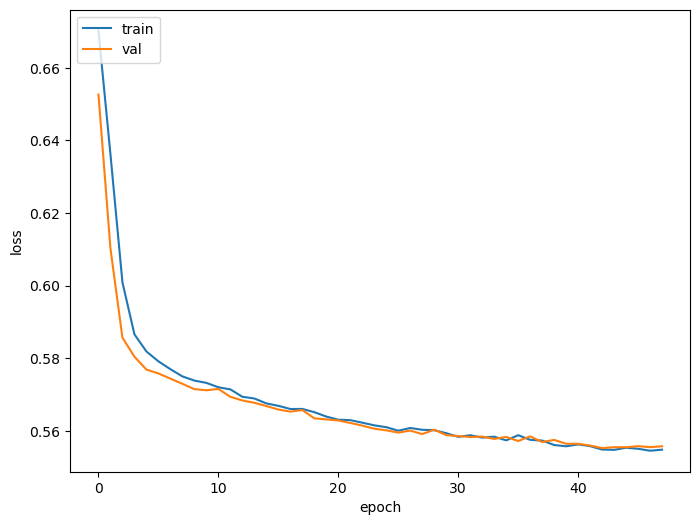

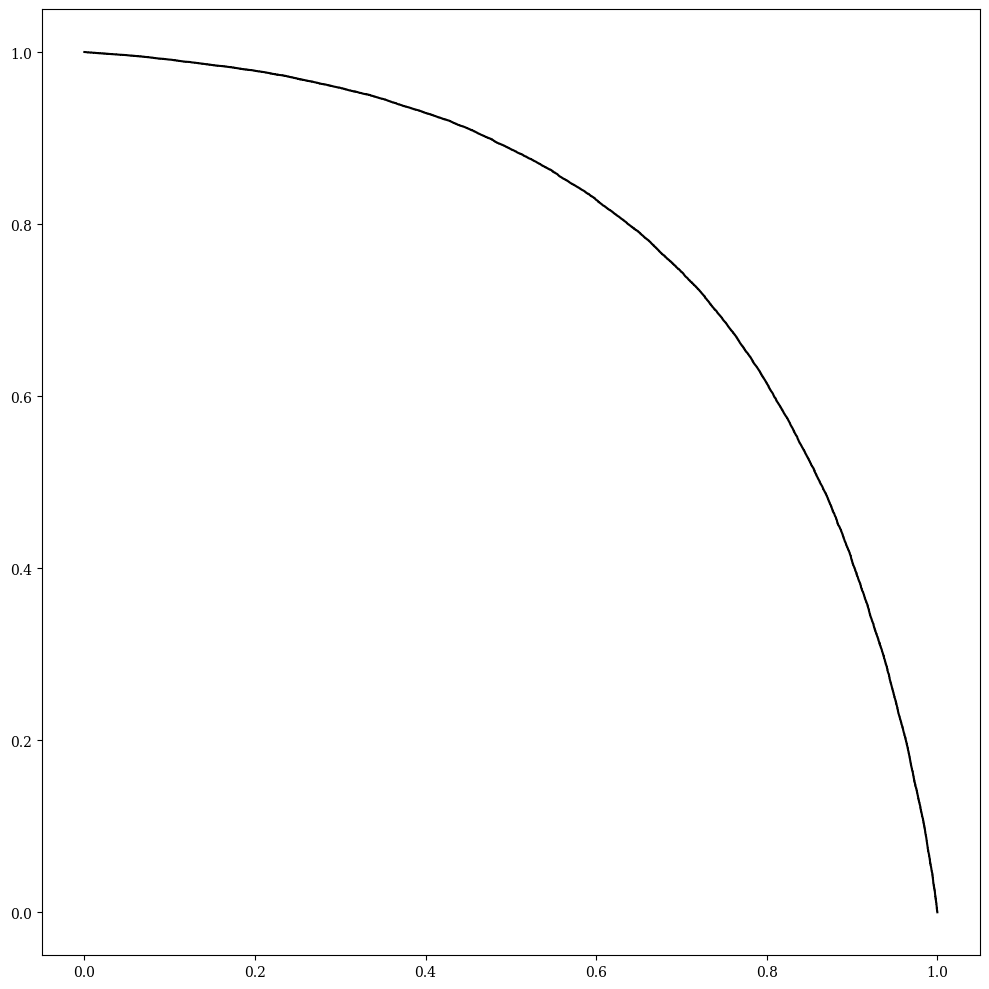

In [3]:
# EFN without spectral normalization
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = False
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta_quarkGluon/EFN_zpT_partlevel_iter{i}.keras")
    del efn
    gc.collect()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 3)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     240         ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation[0][0]']             
                                                                                              

2024-01-08 17:10:53.529317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:10:53.740836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:10:53.741218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:10:53.742095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Epoch 1/200
 2/20 [==>...........................] - ETA: 1s - loss: 1.2854 - acc: 0.5083 

2024-01-08 17:10:56.274903: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 4s 133ms/step - loss: 0.8729 - acc: 0.5708 - val_loss: 0.6191 - val_acc: 0.6738
Epoch 2/200
20/20 [==============================] - 2s 115ms/step - loss: 0.6255 - acc: 0.6639 - val_loss: 0.5805 - val_acc: 0.7025
Epoch 3/200
20/20 [==============================] - 2s 118ms/step - loss: 0.5858 - acc: 0.6967 - val_loss: 0.5691 - val_acc: 0.7103
Epoch 4/200
20/20 [==============================] - 2s 115ms/step - loss: 0.5744 - acc: 0.7073 - val_loss: 0.5641 - val_acc: 0.7164
Epoch 5/200
20/20 [==============================] - 2s 117ms/step - loss: 0.5691 - acc: 0.7115 - val_loss: 0.5613 - val_acc: 0.7186
Epoch 6/200
20/20 [==============================] - 2s 115ms/step - loss: 0.5664 - acc: 0.7138 - val_loss: 0.5586 - val_acc: 0.7196
Epoch 7/200
20/20 [==============================] - 2s 115ms/step - loss: 0.5637 - acc: 0.7161 - val_loss: 0.5576 - val_acc: 0.7204
Epoch 8/200
20/20 [==============================] - 2s 119ms/step - loss: 0.5615

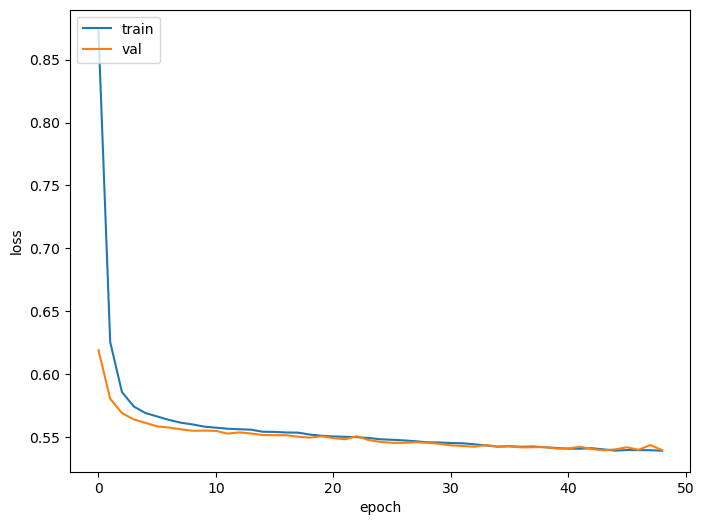

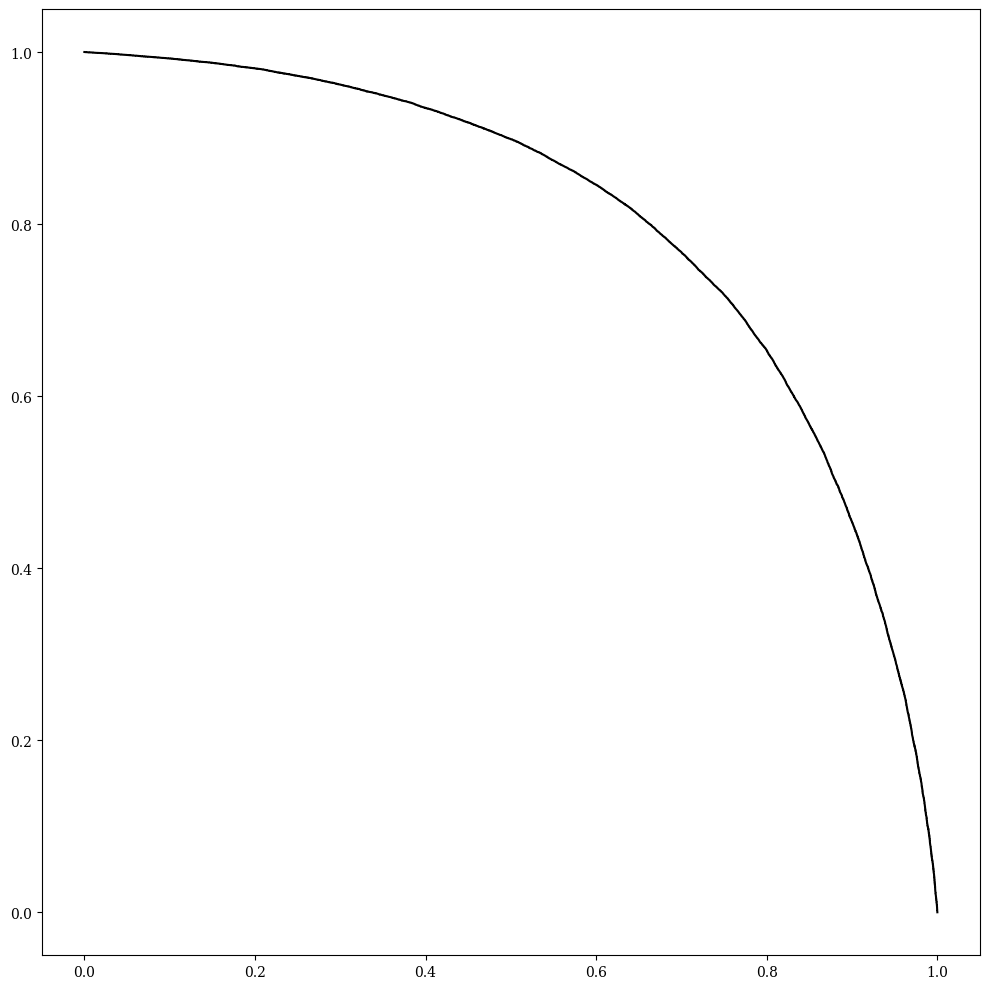

In [3]:
# PFN without spectral normalization
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":3,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = False
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_pfn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta_quarkGluon/PFN_zpT_partlevel_iter{i}.keras")
    del efn
    gc.collect()

2024-01-08 17:16:10.052206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:16:10.273806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:16:10.274138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-08 17:16:10.275475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 3)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     481         ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation[0][0]']             
                                                                                              

2024-01-08 17:16:12.264148: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200
20/20 [==============================] - 5s 153ms/step - loss: 0.6699 - acc: 0.5387 - val_loss: 0.6494 - val_acc: 0.6101
Epoch 2/200
20/20 [==============================] - 3s 130ms/step - loss: 0.6381 - acc: 0.6673 - val_loss: 0.6183 - val_acc: 0.6961
Epoch 3/200
20/20 [==============================] - 3s 133ms/step - loss: 0.6132 - acc: 0.6913 - val_loss: 0.5963 - val_acc: 0.7025
Epoch 4/200
20/20 [==============================] - 3s 132ms/step - loss: 0.5972 - acc: 0.6974 - val_loss: 0.5853 - val_acc: 0.7047
Epoch 5/200
20/20 [==============================] - 3s 133ms/step - loss: 0.5876 - acc: 0.7015 - val_loss: 0.5786 - val_acc: 0.7068
Epoch 6/200
20/20 [==============================] - 3s 131ms/step - loss: 0.5813 - acc: 0.7028 - val_loss: 0.5738 - val_acc: 0.7088
Epoch 7/200
20/20 [==============================] - 3s 131ms/step - loss: 0.5779 - acc: 0.7045 - val_loss: 0.5719 - val_acc: 0.7098
Epoch 8/200
20/20 [==============================] - 3s 130ms/step - 

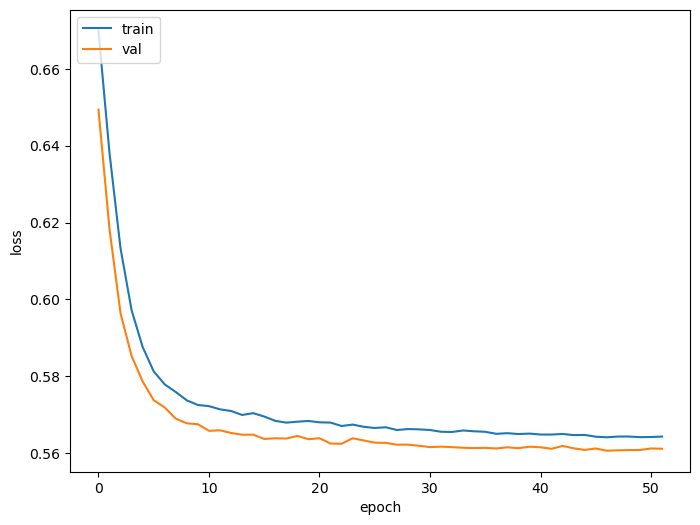

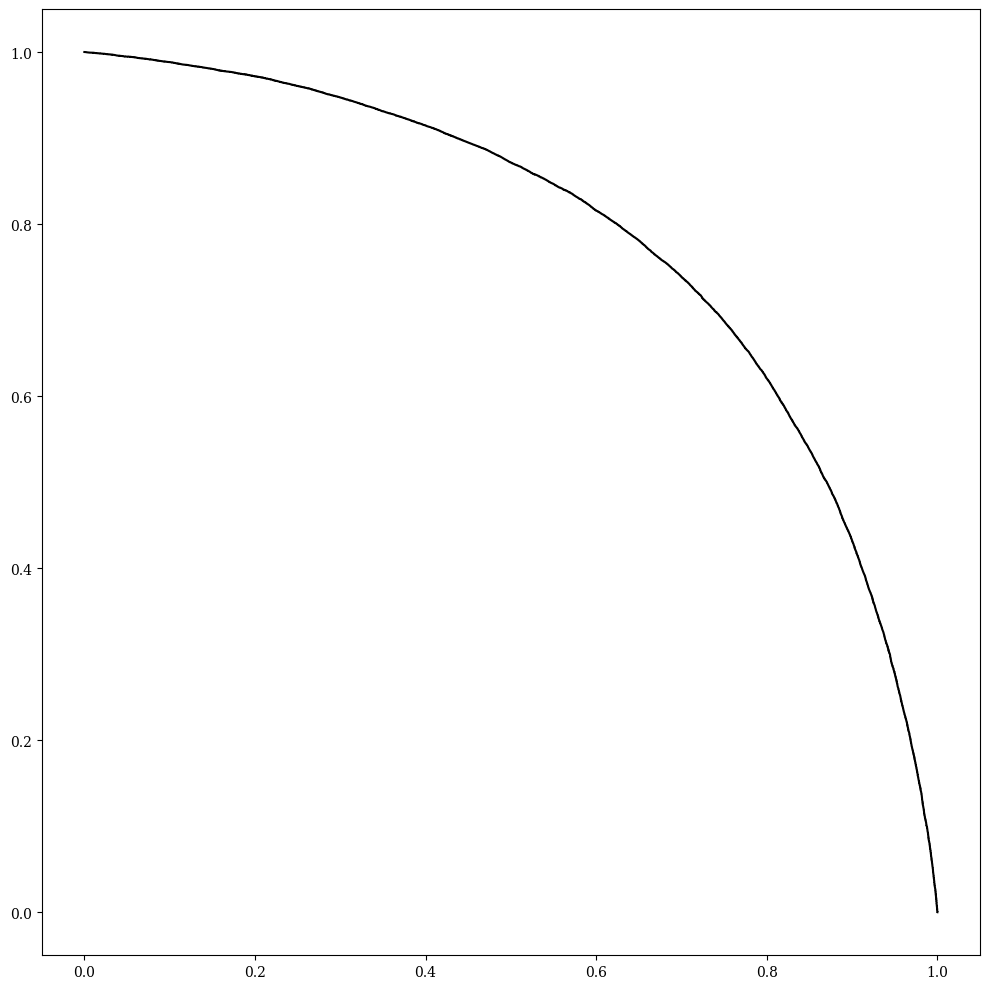

In [3]:
# PFN with spectral normalization
for i in range(1):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":3,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_pfn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta_quarkGluon/spectralPFN_zpT_partlevel_iter{i}.keras")
    del efn
    gc.collect()